In [57]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import pickle
import cv2
from tifffile import imread, imwrite

In [2]:
pth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide'

pth_cell_contours = os.path.join(pth,'stardist_stuff/L0001_cell_contours.geojson')

pth_gene_exp_dat = os.path.join(pth, 'cnts-super')
pth_gene_exp_image = os.path.join(pth, 'cnts-super-plots')

gene_exp_dat_list = [os.path.join(pth_gene_exp_dat,f) for f in os.listdir(pth_gene_exp_dat) if f.endswith('.pickle')]
gene_exp_image_list = [os.path.join(pth_gene_exp_image,f) for f in os.listdir(pth_gene_exp_image) if f.endswith('.png')]

In [3]:
with open(pth_cell_contours) as f:
    json_dat = json.load(f)

# list of xy coordinates
contours = [i['geometry']['coordinates'] for i in json_dat]

/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/cnts-super/KRT17.pickle


(0.0, 1168.0, 560.0, 0.0)

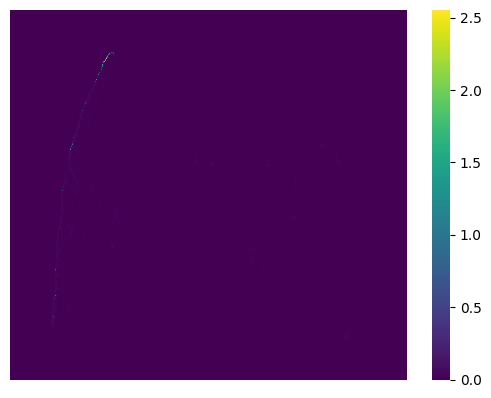

In [5]:
# pickle data is a matrix that is basically a downsampled H&E image, 
# each entry in the matrix is the gene exp value for that gene in that pixel of the ds image
for pickle_pth in gene_exp_dat_list:
    print(pickle_pth)
    with open(pickle_pth, 'rb') as f:
        data = pickle.load(f)
    break

sns.heatmap(data, annot=False, cmap='viridis')
plt.axis('off')

I need to get the cell contours and the heatmap data into the same coordinate frame now

In [17]:
# this data is from "run_on_skin_coda.sh":
# /home/donald/Documents/istar/run_on_skin_coda.sh
rescale = 0.4416/0.5

ndpi_pth = '/home/donald/Desktop/Andre_expansion/data/Skin Lymphedema/L0001_diseased/L0001_diseased_0001.ndpi'
img = imread(ndpi_pth)
img_size = img.shape
print(img_size)

rescale_size = [round(img_size[0]*rescale), round(img_size[1]*rescale)]
print(rescale_size)

padded_size = [rescale_size[0]//256 + rescale_size[0], rescale_size[0]//256 + rescale_size[1]]
print(padded_size)

(9856, 21120, 3)
[8705, 18653]
[8739, 18687]


In [73]:
# first, make a tif file from the contours to the rescaled range:
adj_contours = []
for nuc in contours:
    adj_nuc = []
    for xy in nuc[0]:
        xy_formatted = (xy[0]*rescale, xy[1]*rescale)
        adj_nuc.append(xy_formatted)
    adj_contours.append(adj_nuc)

NEED TO CHANGE THIS IF > 2^16 number of nuclei in WSI (LIKELY THE CASE)

In [75]:
# Create a blank image to serve as the mask (same size as rescale_size)
mask = np.zeros(rescale_size[:2], dtype=np.uint16)

# Assign an instance ID for each polygon (or use different colors for each)
for i, polygon in enumerate(adj_contours):
    # Convert the polygon list to a NumPy array
    polygon_np = np.array(polygon, dtype=np.int32)
    
    # Fill the polygon with a unique color or ID (e.g., i+1 for instance ID)
    cv2.fillPoly(mask, [polygon_np], color=(i + 1))

# save tif
outpth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/contours_tif_rescale/he-scaled.jpg'
imwrite(outpth, mask)

conda activate istar
pth="/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/contours_tif_rescale/"
python /home/donald/Documents/istar/preprocess.py $pth --image

Now, the contour image mask should be the same exact size as the scaled and processed image, such that the contour mask image is in 0.5 um/pix resolution and the width and height are divisible by 256

Now, we can scale the gene expression matrices up and then do matrix operations with the contour masks to get expression of each gene for each cell efficiently

In [ ]:
for pickle_pth in gene_exp_dat_list:
    print(pickle_pth)
    with open(pickle_pth, 'rb') as f:
        data = pickle.load(f)
    break

In [77]:
processed_contour_tif_pth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/contours_tif_rescale/he.tif'
contour_im = imread(processed_contour_tif_pth)

In [79]:
print(data.shape)
print(contour_im.shape)

(560, 1168)
(8960, 18688)


In [81]:
print(8960/560)
print(18688/1168)

16.0
16.0


In [83]:
# bicubic interp
from scipy.ndimage import zoom

In [88]:
for i in cell_dict:
    print(i)
    break

0


In [94]:
print(contour_im.shape)
print(upscaled_data.shape)

(8960, 18688)
(8960, 18688)


In [109]:
sums[label - 1]

0.0

In [118]:
zoom_factor = 16

outpth = '/home/donald/Desktop/Andre_expansion/students/Donald/data/Skin_visium/lymph_spacerangerL1/binned_outputs/square_016um/iStar_data/test_on_new_slide/stardist_stuff/contours_tif_rescale/gene_exp_dicts_per_cell'

for pickle_pth in gene_exp_dat_list:
    print(os.path.basename(pickle_pth))

    outnm = os.path.join(outpth, os.path.basename(pickle_pth))
    if not os.path.exists(outnm):
        with open(pickle_pth, 'rb') as f:
            data = pickle.load(f)
            
            # Upscale the data
            upscaled_data = zoom(data, zoom_factor, order=3)

            # Create an array to hold the sums for each label
            unique_labels = np.unique(contour_im)
            sums = np.zeros(unique_labels.max() + 1)  # Create an array for all possible labels

            # Accumulate sums in a vectorized manner
            np.add.at(sums, contour_im.flatten(), upscaled_data.flatten())

            # Store the results in cell_dict, excluding background (0)
            cell_dict = {label: sums[label] for label in unique_labels if label != 0}

            outnm = os.path.join(outpth, os.path.basename(pickle_pth))
            with open(outnm, 'wb') as f:
                pickle.dump(cell_dict, f)


KRT17.pickle
FLG.pickle
CALML5.pickle
LOR.pickle
SBSN.pickle
SPRR2G.pickle
KRT16.pickle
SLC2A1.pickle
IFFO2.pickle
ASPRV1.pickle
DSG1.pickle
FGFR3.pickle
LY6D.pickle
FLG2.pickle
KRT15.pickle
TACSTD2.pickle
DST.pickle
ACTN4.pickle
LCE1C.pickle
HOPX.pickle
IGHG1.pickle
S100A2.pickle
FCGBP.pickle
TAGLN.pickle
DSC3.pickle
MYL6.pickle
EPPK1.pickle
TIMP3.pickle
NDRG1.pickle
GSTP1.pickle
ACTA2.pickle
PFN1.pickle
OAZ1.pickle
CDSN.pickle
TMEM45A.pickle
C3.pickle
YBX3.pickle
LCE1A.pickle
DEGS1.pickle
DSC1.pickle
LGALS3.pickle
AQP3.pickle
MGP.pickle
C1S.pickle
GSN.pickle
IGFBP4.pickle
C1R.pickle
MT-ATP6.pickle
APOD.pickle
APCDD1.pickle
RACK1.pickle
MT-ND1.pickle
CD9.pickle
PSAP.pickle
CTNNBIP1.pickle
MT-ND4L.pickle
COL6A3.pickle
UBA52.pickle
CSRP1.pickle
ZFP36L2.pickle
ZFP36L1.pickle
COL5A1.pickle
SDC1.pickle
CALD1.pickle
MAF.pickle
KLF5.pickle
C1orf68.pickle
SPRR5.pickle
LAMP1.pickle
SELENOW.pickle
LYZ.pickle
CLDN1.pickle
TNXB.pickle
S100A14.pickle
S100A4.pickle
ITM2B.pickle
COL4A2.pickle
S100A1

In [101]:
np.sum(pixs)

418

In [97]:
np.sum(pixs)

155120598

In [85]:
upscaled_data.shape

(8960, 18688)